<a href="https://colab.research.google.com/github/Anshum-Bhargav/Residential-Property-Price-Detection/blob/main/IF_DS_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb


In [6]:
pd.set_option('display.max_columns',None)
plt.style.use('seaborn-v0_8-darkgrid')



In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
print(f"Training data shape: {train.shape}")

Training data shape: (1460, 81)


In [9]:
print(f"Test data shape: {test.shape}")

Test data shape: (1459, 80)


In [10]:
test_IDs = test['Id']

In [11]:
print("\n The first 5 rows of training data:")
print(train.head())


 The first 5 rows of training data:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1

Doing Exploratory Data analysis now

In [12]:
print("<- Basic Statistics ->")
print(train.describe())

<- Basic Statistics ->
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.09

In [13]:
print("\n <- Sales Price Statistics ->")
print(train['SalePrice'].describe())


 <- Sales Price Statistics ->
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


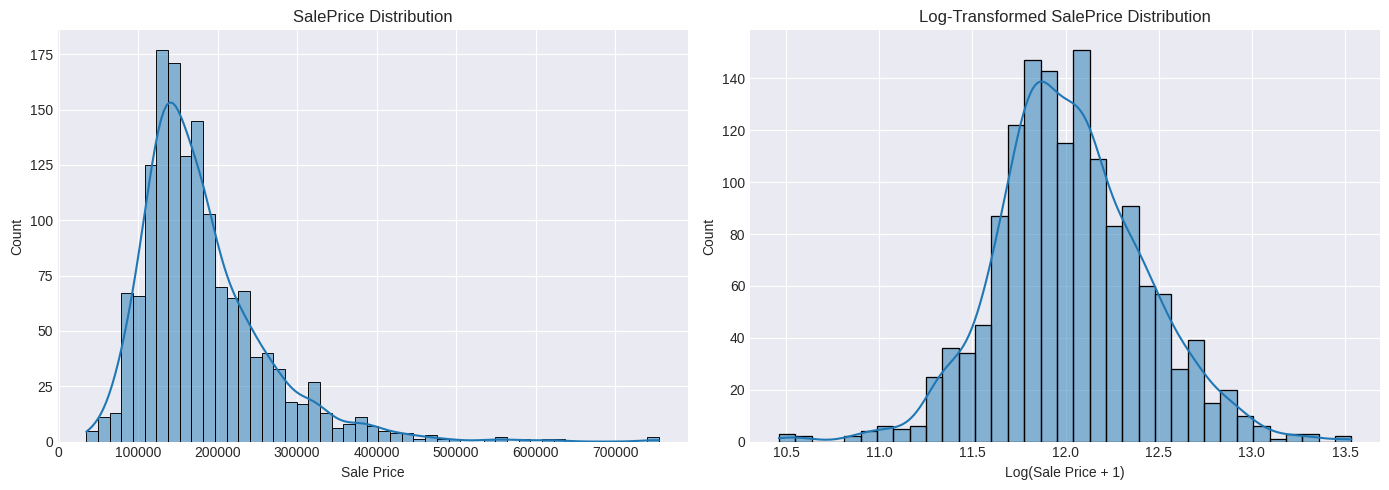

In [14]:
# Visualize SalePrice distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution
sns.histplot(train['SalePrice'], kde=True, ax=axes[0])
axes[0].set_title('SalePrice Distribution')
axes[0].set_xlabel('Sale Price')

# Log-transformed distribution
sns.histplot(np.log1p(train['SalePrice']), kde=True, ax=axes[1])
axes[1].set_title('Log-Transformed SalePrice Distribution')
axes[1].set_xlabel('Log(Sale Price + 1)')

plt.tight_layout()
plt.show()

In [15]:
print(f"\nSalePrice Skewness: {train['SalePrice'].skew()}")
print(f"SalePrice Kurtosis: {train['SalePrice'].kurt()}")



SalePrice Skewness: 1.8828757597682129
SalePrice Kurtosis: 6.536281860064529


In [16]:
# Missing Values
missing_train = train.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)
missing_percent = (missing_train / len(train)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_train,
    'Percentage': missing_percent
})
print(missing_df.head(20))

              Missing_Count  Percentage
PoolQC                 1453   99.520548
MiscFeature            1406   96.301370
Alley                  1369   93.767123
Fence                  1179   80.753425
MasVnrType              872   59.726027
FireplaceQu             690   47.260274
LotFrontage             259   17.739726
GarageType               81    5.547945
GarageYrBlt              81    5.547945
GarageFinish             81    5.547945
GarageQual               81    5.547945
GarageCond               81    5.547945
BsmtExposure             38    2.602740
BsmtFinType2             38    2.602740
BsmtQual                 37    2.534247
BsmtCond                 37    2.534247
BsmtFinType1             37    2.534247
MasVnrArea                8    0.547945
Electrical                1    0.068493


In [17]:
# Select only numerical features for correlation
numerical_features = train.select_dtypes(include=[np.number]).columns.tolist()

# Top correlations with SalePrice
correlations = train[numerical_features].corr()['SalePrice'].sort_values(ascending=False)
print("\n<- Top 15 Features Correlated with SalePrice ->")
print(correlations.head(15))


<- Top 15 Features Correlated with SalePrice ->
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


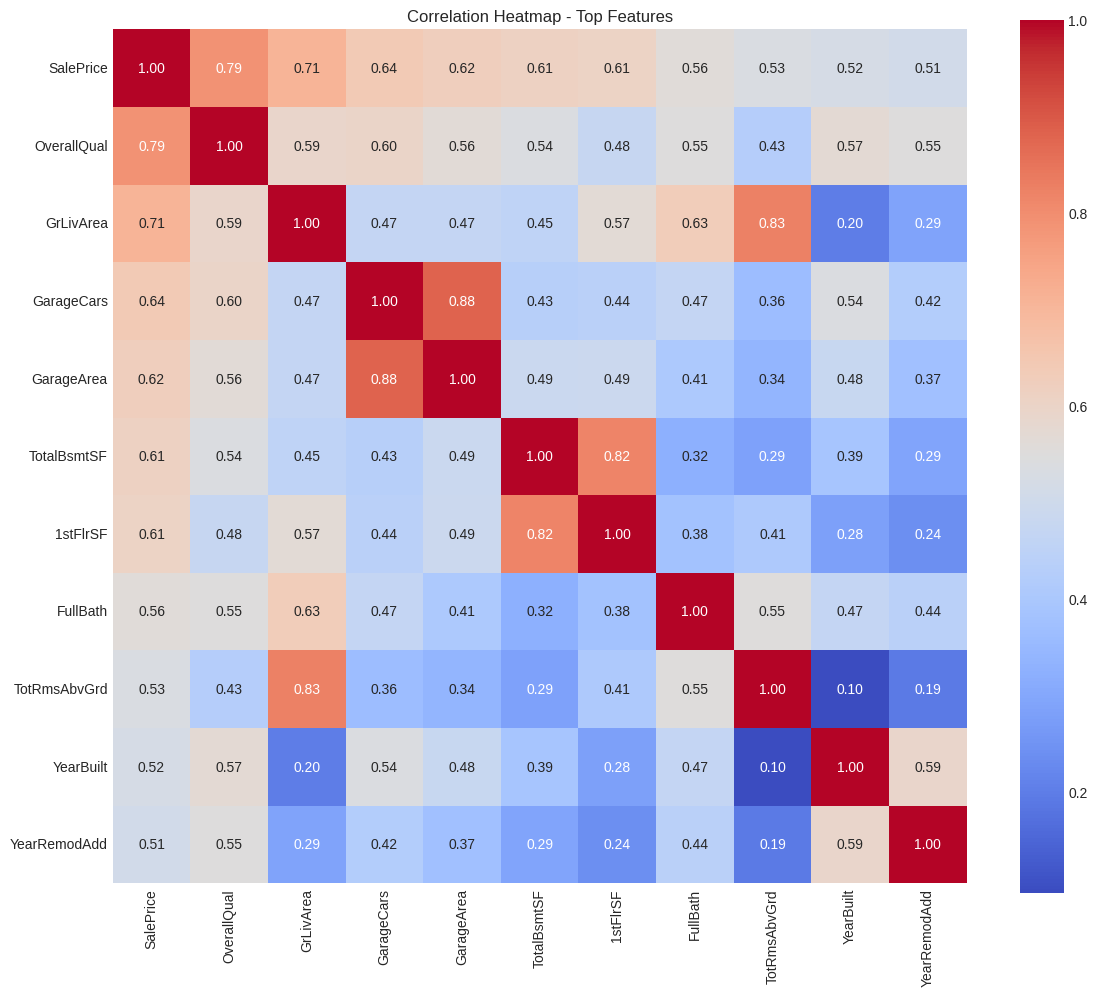

In [18]:
# Visualize correlation heatmap
plt.figure(figsize=(12, 10))
top_corr_features = correlations.head(11).index
sns.heatmap(train[top_corr_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap - Top Features')
plt.tight_layout()


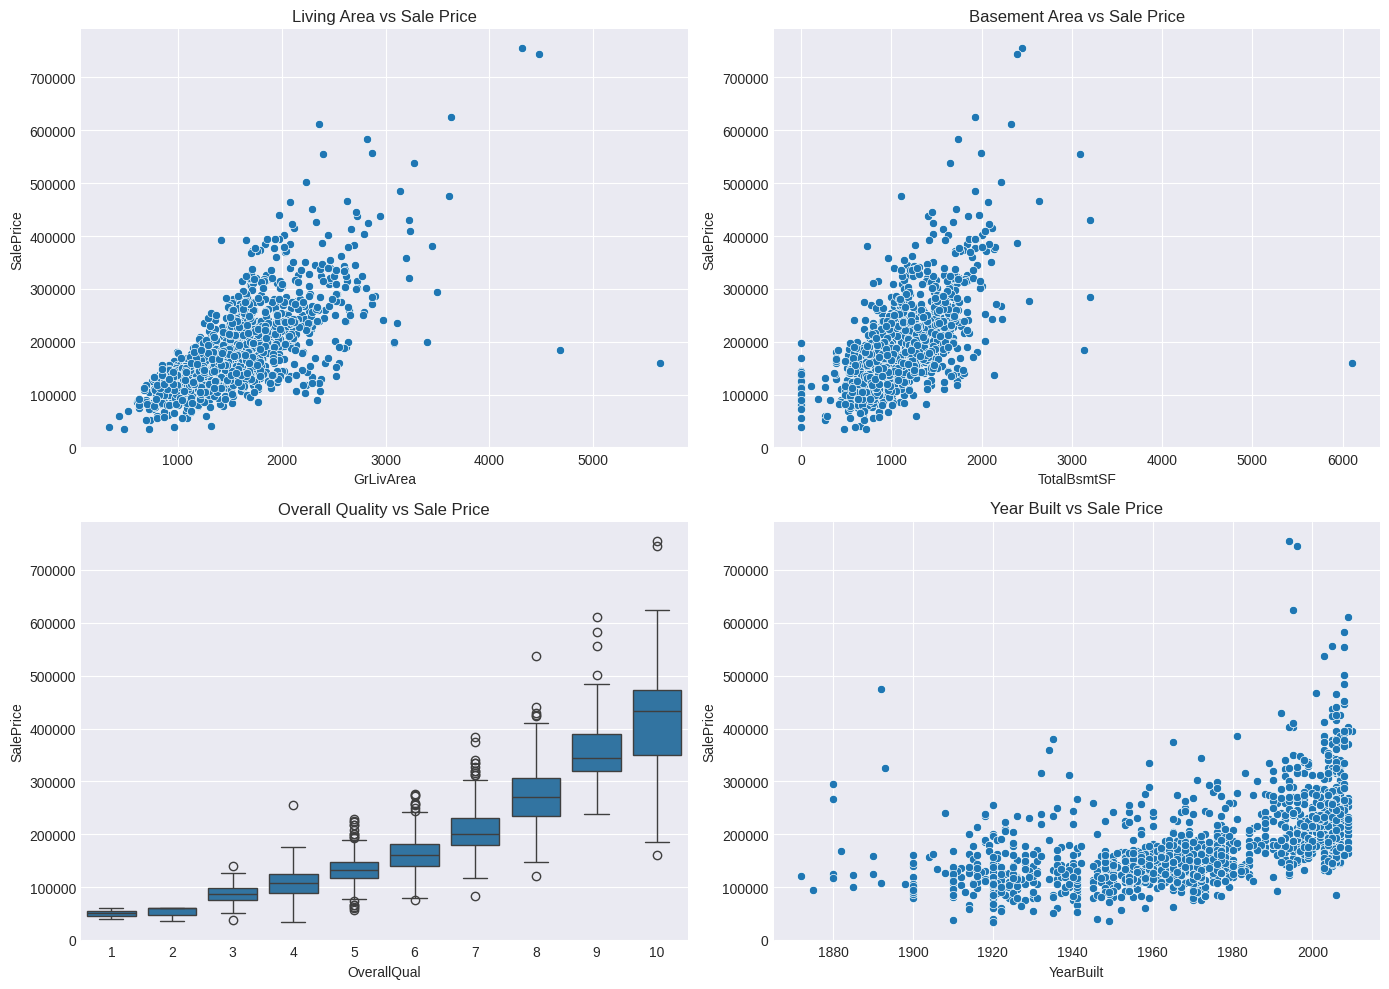

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.scatterplot(data=train, x='GrLivArea', y='SalePrice', ax=axes[0, 0])
axes[0, 0].set_title('Living Area vs Sale Price')

sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice', ax=axes[0, 1])
axes[0, 1].set_title('Basement Area vs Sale Price')

sns.boxplot(data=train, x='OverallQual', y='SalePrice', ax=axes[1, 0])
axes[1, 0].set_title('Overall Quality vs Sale Price')

sns.scatterplot(data=train, x='YearBuilt', y='SalePrice', ax=axes[1, 1])
axes[1, 1].set_title('Year Built vs Sale Price')

plt.tight_layout()


Data Preprocessing


In [20]:
# Removing Outliers
train = train[train['GrLivArea'] < 4000]
print(f"Training data shape after removing outliers: {train.shape}")


Training data shape after removing outliers: (1456, 81)


In [21]:
y_train = train['SalePrice'].copy()
train = train.drop(['SalePrice'], axis=1)
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)
print(f"\nCombined dataset shape: {all_data.shape}")


Combined dataset shape: (2915, 80)


In [22]:
all_data = all_data.drop(['Id'], axis=1)


Handling Missing Values

In [23]:
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType']

for col in none_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna('None')

In [24]:
zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars',
             'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
             'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

for col in zero_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)


In [25]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [26]:
# Fill remaining categorical with mode
categorical_cols = all_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if all_data[col].isnull().sum() > 0:
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [27]:
# Fill remaining numerical with median
numerical_cols = all_data.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if all_data[col].isnull().sum() > 0:
        all_data[col] = all_data[col].fillna(all_data[col].median())

In [28]:
print(f"Missing values after handling: {all_data.isnull().sum().sum()}")

Missing values after handling: 0


ok 👍

Feature Engineering

In [29]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [30]:
# Total Bathrooms
all_data['TotalBath'] = (all_data['FullBath'] +
                         0.5 * all_data['HalfBath'] +
                         all_data['BsmtFullBath'] +
                         0.5 * all_data['BsmtHalfBath'])

# Total Porch Area
all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] +
                            all_data['3SsnPorch'] +
                            all_data['EnclosedPorch'] +
                            all_data['ScreenPorch'] +
                            all_data['WoodDeckSF'])

In [31]:
# House Age
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']

In [32]:
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['Has2ndFloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasBsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasFireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Quality Scores
all_data['OverallScore'] = all_data['OverallQual'] * all_data['OverallCond']

print(f"Dataset shape after feature engineering: {all_data.shape}")

Dataset shape after feature engineering: (2915, 90)


Fix Skewed Features


In [33]:
# Get numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check skewness of all numeric features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_feats})

# Fix skewness
skewness = skewness[abs(skewness['Skew']) > 0.75]
print(f"There are {len(skewness)} skewed numerical features to transform")

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 26 skewed numerical features to transform


In [34]:
print("\n=== Encoding Categorical Variables ===")

# Get categorical columns
categorical_cols = all_data.select_dtypes(include=['object']).columns

# Use one-hot encoding
all_data = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True)

print(f"Dataset shape after encoding: {all_data.shape}")


=== Encoding Categorical Variables ===
Dataset shape after encoding: (2915, 269)


Split Back to Train and Test

In [35]:
train_processed = all_data[:ntrain]
test_processed = all_data[ntrain:]

print(f"\nProcessed training data shape: {train_processed.shape}")
print(f"Processed test data shape: {test_processed.shape}")

# Also transform target variable
y_train_log = np.log1p(y_train)



Processed training data shape: (1456, 269)
Processed test data shape: (1459, 269)


Build and Train Models

In [36]:
def rmse_cv(model, X, y, cv=5):
    kf = KFold(cv, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                     scoring="neg_mean_squared_error",
                                     cv=kf))
    return rmse

In [37]:
print("\n--- Linear Regression ---")
lr = LinearRegression()
lr_scores = rmse_cv(lr, train_processed, y_train_log)
print(f"Linear Regression RMSE: {lr_scores.mean():.4f} (+/- {lr_scores.std():.4f})")


--- Linear Regression ---
Linear Regression RMSE: 0.1215 (+/- 0.0049)


In [38]:
print("\n--- Ridge Regression ---")
ridge = Ridge(alpha=10, random_state=42)
ridge_scores = rmse_cv(ridge, train_processed, y_train_log)
print(f"Ridge RMSE: {ridge_scores.mean():.4f} (+/- {ridge_scores.std():.4f})")


--- Ridge Regression ---
Ridge RMSE: 0.1121 (+/- 0.0078)


In [39]:
print("\n--- Lasso Regression ---")
lasso = Lasso(alpha=0.0005, random_state=42, max_iter=10000)
lasso_scores = rmse_cv(lasso, train_processed, y_train_log)
print(f"Lasso RMSE: {lasso_scores.mean():.4f} (+/- {lasso_scores.std():.4f})")


--- Lasso Regression ---
Lasso RMSE: 0.1124 (+/- 0.0075)


In [40]:
print("\n--- ElasticNet ---")
elasticnet = ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42, max_iter=10000)
en_scores = rmse_cv(elasticnet, train_processed, y_train_log)
print(f"ElasticNet RMSE: {en_scores.mean():.4f} (+/- {en_scores.std():.4f})")



--- ElasticNet ---
ElasticNet RMSE: 0.1124 (+/- 0.0076)


In [41]:
print("\n--- Random Forest ---")
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_scores = rmse_cv(rf, train_processed, y_train_log)
print(f"Random Forest RMSE: {rf_scores.mean():.4f} (+/- {rf_scores.std():.4f})")


--- Random Forest ---
Random Forest RMSE: 0.1345 (+/- 0.0107)


In [42]:
print("\n--- Gradient Boosting ---")
gb = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
                                max_depth=4, random_state=42)
gb_scores = rmse_cv(gb, train_processed, y_train_log)
print(f"Gradient Boosting RMSE: {gb_scores.mean():.4f} (+/- {gb_scores.std():.4f})")


--- Gradient Boosting ---
Gradient Boosting RMSE: 0.1254 (+/- 0.0092)


In [43]:
print("\n--- XGBoost ---")
xgboost = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05,
                           max_depth=4, random_state=42)
xgb_scores = rmse_cv(xgboost, train_processed, y_train_log)
print(f"XGBoost RMSE: {xgb_scores.mean():.4f} (+/- {xgb_scores.std():.4f})")


--- XGBoost ---
XGBoost RMSE: 0.1244 (+/- 0.0090)


In [44]:
print("\n--- LightGBM ---")
lightgbm = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05,
                             max_depth=4, random_state=42, verbose=-1)
lgb_scores = rmse_cv(lightgbm, train_processed, y_train_log)
print(f"LightGBM RMSE: {lgb_scores.mean():.4f} (+/- {lgb_scores.std():.4f})")


--- LightGBM ---
LightGBM RMSE: 0.1221 (+/- 0.0088)


In [45]:
print("\n<= Creating Ensemble Model =>")

# Train all models on full training data
lasso.fit(train_processed, y_train_log)
ridge.fit(train_processed, y_train_log)
elasticnet.fit(train_processed, y_train_log)
gb.fit(train_processed, y_train_log)
xgboost.fit(train_processed, y_train_log)
lightgbm.fit(train_processed, y_train_log)

# Make predictions
pred_lasso = lasso.predict(test_processed)
pred_ridge = ridge.predict(test_processed)
pred_en = elasticnet.predict(test_processed)
pred_gb = gb.predict(test_processed)
pred_xgb = xgboost.predict(test_processed)
pred_lgb = lightgbm.predict(test_processed)

# Ensemble: Average predictions (you can also use weighted average)
ensemble_pred = (0.1 * pred_lasso +
                 0.1 * pred_ridge +
                 0.1 * pred_en +
                 0.2 * pred_gb +
                 0.25 * pred_xgb +
                 0.25 * pred_lgb)

# Convert back from log scale
final_predictions = np.expm1(ensemble_pred)

print("Ensemble model created and predictions made!")



<= Creating Ensemble Model =>
Ensemble model created and predictions made!


Submission File


In [46]:
print("\n=== Creating Submission File ===")

submission = pd.DataFrame({
    'Id': test_IDs,
    'SalePrice': final_predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully!")
print(f"\nFirst few predictions:")
print(submission.head(10))


=== Creating Submission File ===
Submission file 'submission.csv' created successfully!

First few predictions:
     Id      SalePrice
0  1461  122764.583275
1  1462  159891.765823
2  1463  176360.778057
3  1464  193831.784280
4  1465  189052.600693
5  1466  176796.274161
6  1467  182998.352458
7  1468  167316.099835
8  1469  190071.982812
9  1470  120920.482482



Top 20 Most Important Features:
                  feature  importance
3             OverallQual    0.217336
36                TotalSF    0.137661
205          CentralAir_Y    0.061008
212        KitchenQual_TA    0.048196
25             GarageCars    0.047677
21           KitchenAbvGr    0.029096
46           OverallScore    0.027929
228     GarageType_Detchd    0.025702
23             Fireplaces    0.024801
37              TotalBath    0.024718
56           LotShape_Reg    0.023921
50            MSZoning_RM    0.015724
162          ExterQual_TA    0.015667
237         GarageQual_TA    0.014201
39               HouseAge    0.013949
83   Neighborhood_OldTown    0.013769
52             Alley_None    0.013077
49            MSZoning_RL    0.010989
232      GarageFinish_Unf    0.010133
242         GarageCond_TA    0.009592


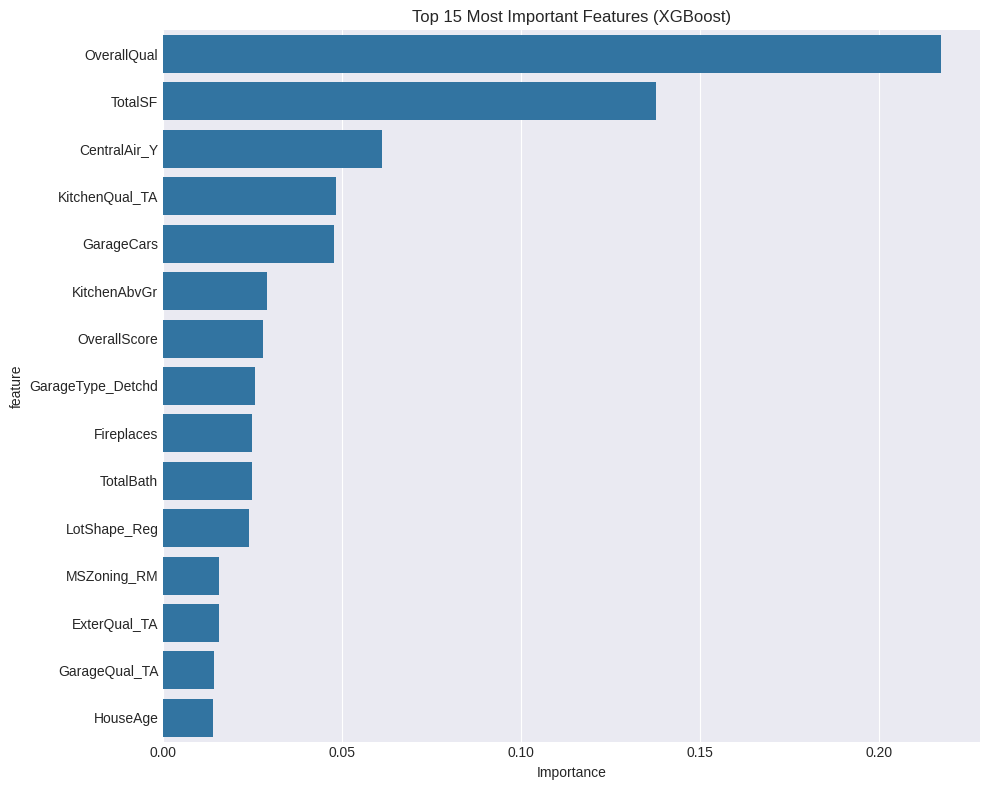

In [47]:
feature_importance = pd.DataFrame({
    'feature': train_processed.columns,
    'importance': xgboost.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, y='feature', x='importance')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.xlabel('Importance')
plt.tight_layout()

In [48]:
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM'],
    'RMSE': [lr_scores.mean(), ridge_scores.mean(), lasso_scores.mean(),
             en_scores.mean(), rf_scores.mean(), gb_scores.mean(),
             xgb_scores.mean(), lgb_scores.mean()],
    'Std': [lr_scores.std(), ridge_scores.std(), lasso_scores.std(),
            en_scores.std(), rf_scores.std(), gb_scores.std(),
            xgb_scores.std(), lgb_scores.std()]
})

results = results.sort_values('RMSE')
print("\n", results.to_string(index=False))

print("\n" + "="*60)


MODEL PERFORMANCE SUMMARY

             Model     RMSE      Std
            Ridge 0.112127 0.007785
       ElasticNet 0.112395 0.007623
            Lasso 0.112410 0.007544
Linear Regression 0.121452 0.004910
         LightGBM 0.122093 0.008828
          XGBoost 0.124408 0.009022
Gradient Boosting 0.125367 0.009193
    Random Forest 0.134545 0.010709

